In [186]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [187]:
import numpy as np
import pandas as pd

In [188]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [189]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [190]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [191]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [192]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [193]:
# Save references to each table
measurement = Base.classes.measurement
station_table = Base.classes.station

In [194]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [195]:
inspector = inspect(engine)

In [196]:
# See what I'm even looking at with these tables (repeating the classes.keys)

inspector.get_table_names()

columns_measure = inspector.get_columns('measurement')
for column in columns_measure:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [197]:
# See what I'm even looking at with these tables

columns_measure = inspector.get_columns('station')
for column in columns_measure:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [198]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the last data point in the database
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Print last data point
recent_date

('2017-08-23')

In [199]:
# Calculate the date 1 year ago from the last data point in the database

# 2016-08-23 based on last data point

# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(measurement.date, measurement.prcp).\
        filter(measurement.date >= '2016-08-24', measurement.date <= '2017-08-23').\
        order_by(measurement.date).all()
date_prcp


[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

In [200]:
# Save the query results as a Pandas DataFrame
date_prcp_df = pd.DataFrame(date_prcp, columns = ['date', 'precipitation'])

# Set the index to the date column
date_prcp_df.set_index('date', inplace = True)

date_prcp_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


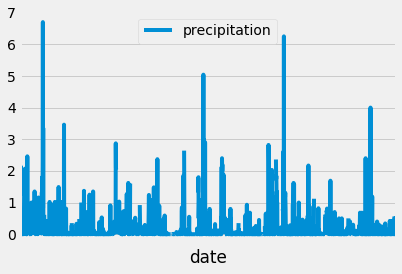

In [201]:
# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values(by = 'date',ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df.plot()
plt.xticks([])
plt.legend(loc = 'upper center')
plt.savefig("Images/precipitation.png")

In [202]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df.describe()


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [203]:
# Design a query to show how many stations are available in this dataset?

station_num = session.query(station.id).count()
station_num

9

In [204]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

# List the stations and the counts in descending order.

active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [205]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_temps = session.query(func.min(measurement.tobs), 
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

most_active_temps

[(54.0, 85.0, 71.66378066378067)]

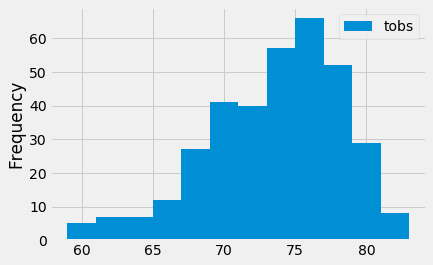

In [206]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(measurement.tobs).\
                                filter(measurement.station == 'USC00519281').\
                                filter(measurement.date >= '2016-08-24').\
                                order_by(measurement.date.desc()).all()

# Set 12 bins for months in year
x = [x[0] for x in histogram]

# Build Histogram
plt.hist(x, bins = 12)
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.savefig("Images/station-histogram.png")
plt.show()


In [207]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [208]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-05-10','2017-05-24')
trip_temps

[(68.0, 74.92857142857143, 87.0)]

In [209]:
# Save as dataframe to be called in plot
trip_temps_df = pd.DataFrame(trip_temps, columns = ['tmin', 'tavg', 'tmax'])
trip_temps_df

,tmin,tavg,tmax
0,68.0,74.928571,87.0


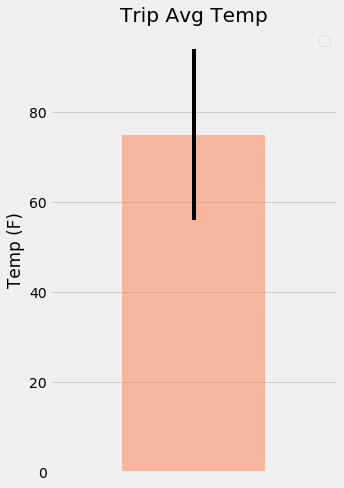

In [210]:
# Plot the results from your previous query as a bar chart.

trip_temps_df.plot.bar(y = 'tavg', 
                       yerr = (trip_temps_df['tmax'] - trip_temps_df['tmin']),
                       title = 'Trip Avg Temp', 
                       color = 'coral', 
                       figsize = (5,7),
                       alpha = 0.5)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.legend('')
plt.tight_layout()
plt.savefig("Images/temperature.png")
plt.show()

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [211]:
# Calculate the total amount of rainfall per weather station
# for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list
# the station, name, latitude, longitude, and elevation.

# Set function and define what it does
def rainfall(start_date, end_date):
    """ Lists station, name, lat, long, elevation, and prcp amount for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        STATION, NAME, LAT, LONG, ELEVATION, and PRCP
    """
    return session.query(measurement.station,
                         station.name,
                         station.latitude,
                         station.longitude,
                         station.elevation,
                         measurement.prcp).\
                            join(station, measurement.station == station.station).\
                            filter(measurement.date >= start_date).\
                            filter(measurement.date <= end_date).\
                            group_by(measurement.station).\
                            order_by(measurement.prcp.desc()).all()

rainfall('2017-05-10','2017-05-24')


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.55),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.2),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.06),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.05),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]